In [1]:
import pandas as pd
%matplotlib inline
import numpy as np

In [4]:
df = pd.read_csv('./data/cdr.csv', index_col='callID')

In [5]:
df.head()

,phoneNumber,Line,destPhoneNumber,startDate,endDate,startTime,endTime,Type,Cost
callID,,,,,,,,,
0,1650333333,1,8450927777,3/1/2014,3/1/2014,11:00:00,11:09:00,National,72
1,1650333333,1,1657777772,22/01/2014,22/01/2014,18:30:00,18:43:00,Local,52
2,1650333333,1,1657777772,27/01/2014,27/01/2014,15:10:00,15:37:00,Local,27
3,1650333333,0,8450927777,5/2/2014,5/2/2014,19:55:00,20:07:00,National,96
4,1650333333,1,1657777777,18/02/2014,18/02/2014,14:35:00,14:52:00,Local,68


**Goal:** Detect unusual activity / patterns.

**Important!**: Determine the level of detail of the analysis. 

- Suspicious *calls* (individual calls).
- Suspicious *callers* (people doing those calls).

### Unusual calls

In [6]:
df.columns

Index([' phoneNumber', ' Line', ' destPhoneNumber', ' startDate', ' endDate',
       ' startTime', ' endTime', ' Type', ' Cost'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 42238 entries, 0 to 220
Data columns (total 9 columns):
 phoneNumber        42238 non-null int64
 Line               42238 non-null int64
 destPhoneNumber    42238 non-null int64
 startDate          42238 non-null object
 endDate            42238 non-null object
 startTime          42238 non-null object
 endTime            42238 non-null object
 Type               42238 non-null object
 Cost               42238 non-null int64
dtypes: int64(4), object(5)
memory usage: 3.2+ MB


#### Preliminary cleaning

- Remove whitespace in columns.
- Set the date/time correctly.

In [13]:
' pablo is in a1   '.strip()

'pablo is in a1'

In [15]:
df.columns = [col.strip() for col in df.columns]

In [17]:
df.columns

Index(['phoneNumber', 'Line', 'destPhoneNumber', 'startDate', 'endDate',
       'startTime', 'endTime', 'Type', 'Cost'],
      dtype='object')

In [19]:
df['startCall'] = pd.to_datetime(df['startDate'] + ' ' + df['startTime'])

In [22]:
df['endCall'] = pd.to_datetime(df['endDate'] + ' ' + df['endTime'])

In [26]:
df['callDuration'] = df['endCall']-df['startCall']

In [32]:
df['callDurationMin'] = df['callDuration'].apply(lambda t: t.seconds/60) # convert to min

In [34]:
df['startCallHour'] = df['startCall'].apply(lambda t: t.hour)

In [35]:
df.head()

,phoneNumber,Line,destPhoneNumber,startDate,endDate,startTime,endTime,Type,Cost,startCall,endCall,callDuration,callDurationMin,startCallHour
callID,,,,,,,,,,,,,,
0,1650333333,1,8450927777,3/1/2014,3/1/2014,11:00:00,11:09:00,National,72,2014-03-01 11:00:00,2014-03-01 11:09:00,00:09:00,9.0,11
1,1650333333,1,1657777772,22/01/2014,22/01/2014,18:30:00,18:43:00,Local,52,2014-01-22 18:30:00,2014-01-22 18:43:00,00:13:00,13.0,18
2,1650333333,1,1657777772,27/01/2014,27/01/2014,15:10:00,15:37:00,Local,27,2014-01-27 15:10:00,2014-01-27 15:37:00,00:27:00,27.0,15
3,1650333333,0,8450927777,5/2/2014,5/2/2014,19:55:00,20:07:00,National,96,2014-05-02 19:55:00,2014-05-02 20:07:00,00:12:00,12.0,19
4,1650333333,1,1657777777,18/02/2014,18/02/2014,14:35:00,14:52:00,Local,68,2014-02-18 14:35:00,2014-02-18 14:52:00,00:17:00,17.0,14


In [36]:
X = df[['Cost', 'callDurationMin', 'startCallHour']]

In [37]:
X.head()

,Cost,callDurationMin,startCallHour
callID,,,
0,72,9.0,11
1,52,13.0,18
2,27,27.0,15
3,96,12.0,19
4,68,17.0,14


### The Outlier Detection Algorithm

In [38]:
from sklearn.neighbors import LocalOutlierFactor

In [49]:
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

In [50]:
y_pred = lof.fit_predict(X)

In [51]:
set(y_pred)

{-1, 1}

In [52]:
df['Outlier'] = y_pred

In [53]:
import matplotlib.pyplot as plt

In [54]:
X.columns

Index(['Cost', 'callDurationMin', 'startCallHour'], dtype='object')

Text(0, 0.5, 'Start Call Hour')

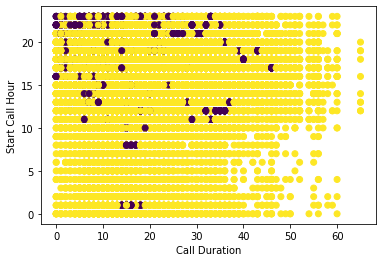

In [55]:
plt.scatter(X['callDurationMin'], X['startCallHour'], c=y_pred)
plt.xlabel('Call Duration')
plt.ylabel('Start Call Hour')

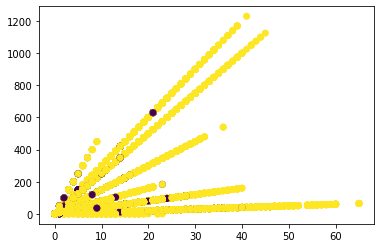

In [56]:
plt.scatter(X['callDurationMin'], X['Cost'], c=y_pred)

In [58]:
df.groupby('Outlier')[['Cost', 'callDurationMin', 'startCallHour']].mean()

,Cost,callDurationMin,startCallHour
Outlier,,,
-1,102.701943,15.209100,17.867587
1,107.100640,18.011966,16.462167


In [61]:
lof.fit_predict(X[['Cost']])

array([1, 1, 1, ..., 1, 1, 1])

## Unusual activity - Phone Number level

In [62]:
df.columns

Index(['phoneNumber', 'Line', 'destPhoneNumber', 'startDate', 'endDate',
       'startTime', 'endTime', 'Type', 'Cost', 'startCall', 'endCall',
       'callDuration', 'callDurationMin', 'startCallHour', 'Outlier'],
      dtype='object')

In [63]:
df.drop(columns=['Outlier'], inplace=True)

In [65]:
call_history = df.groupby('phoneNumber')[['destPhoneNumber', 'callDurationMin', 'startCallHour', 'Cost']].agg({
    'destPhoneNumber':'count', 
    'callDurationMin':'mean', 
    'startCallHour':'mean', 
    'Cost':'mean'
})

In [66]:
call_history.head()

,destPhoneNumber,callDurationMin,startCallHour,Cost
phoneNumber,,,,
1135222222,367,20.264305,16.694823,133.234332
1142444444,389,20.053985,16.331620,132.506427
1159888888,470,16.444681,16.244681,89.819149
1185333333,370,15.727027,16.845946,105.575676
1229211111,376,29.829787,16.446809,170.446809


In [78]:
call_types=df.pivot_table(index='phoneNumber', columns='Type', values='destPhoneNumber',aggfunc='count').fillna(0)

In [79]:
call_types.head()

Type,Free,Intl,Local,Mobile,National,PRS
phoneNumber,,,,,,
1135222222,4.0,26.0,224.0,71.0,40.0,2.0
1142444444,2.0,32.0,228.0,74.0,53.0,0.0
1159888888,4.0,30.0,305.0,78.0,50.0,3.0
1185333333,2.0,27.0,222.0,79.0,39.0,1.0
1229211111,2.0,17.0,258.0,60.0,36.0,3.0


In [80]:
X_new = call_history.join(call_types)

In [81]:
X_new.head()

,destPhoneNumber,callDurationMin,startCallHour,Cost,Free,Intl,Local,Mobile,National,PRS
phoneNumber,,,,,,,,,,
1135222222,367,20.264305,16.694823,133.234332,4.0,26.0,224.0,71.0,40.0,2.0
1142444444,389,20.053985,16.331620,132.506427,2.0,32.0,228.0,74.0,53.0,0.0
1159888888,470,16.444681,16.244681,89.819149,4.0,30.0,305.0,78.0,50.0,3.0
1185333333,370,15.727027,16.845946,105.575676,2.0,27.0,222.0,79.0,39.0,1.0
1229211111,376,29.829787,16.446809,170.446809,2.0,17.0,258.0,60.0,36.0,3.0


In [83]:
y_pred_new = LocalOutlierFactor(contamination=0.1).fit_predict(X_new)

In [84]:
X_new['Outlier'] = y_pred_new

In [85]:
X_new.groupby('Outlier').mean()

,destPhoneNumber,callDurationMin,startCallHour,Cost,Free,Intl,Local,Mobile,National,PRS
Outlier,,,,,,,,,,
-1,426.300000,21.874226,16.425146,137.640560,1.900000,27.300000,261.300000,76.900000,57.100000,1.800000
1,417.307692,17.334717,16.545002,102.819225,2.516484,25.659341,259.593407,76.362637,50.769231,2.406593


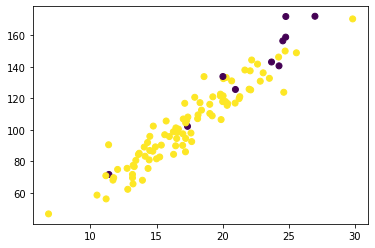

In [87]:
plt.scatter(X_new['callDurationMin'],X_new['Cost'],  c=y_pred_new)

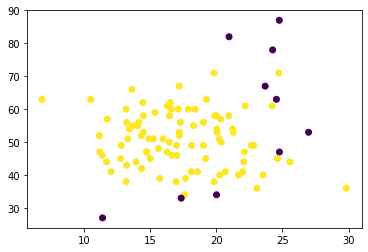

In [88]:
plt.scatter(X_new['callDurationMin'],X_new['National'],  c=y_pred_new)

Text(0.5, 0, 'Average call duration in minutes')

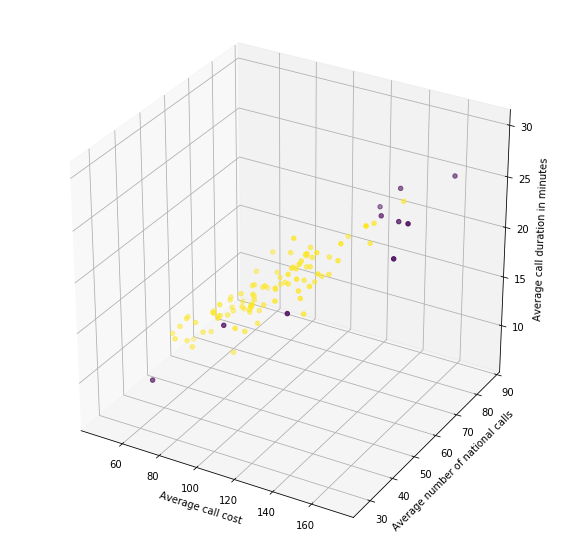

In [94]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_new['Cost'], X_new['National'], X_new['callDurationMin'], c=y_pred_new)
ax.set_xlabel('Average call cost')
ax.set_ylabel('Average number of national calls')
ax.set_zlabel('Average call duration in minutes')

In [99]:
call_types_min=df.pivot_table(index='phoneNumber',columns='Type',values='callDurationMin').fillna(0)

In [100]:
y_ctm = lof.fit_predict(call_types_min)

In [101]:
call_types_min.head()

Type,Free,Intl,Local,Mobile,National,PRS
phoneNumber,,,,,,
1135222222,14.0,24.461538,23.991071,10.859155,14.725000,5.500000
1142444444,8.0,22.687500,24.184211,10.500000,14.490566,0.000000
1159888888,9.0,16.100000,19.904918,8.076923,10.120000,1.000000
1185333333,8.0,16.074074,18.743243,9.911392,10.846154,2.000000
1229211111,20.5,32.647059,33.379845,18.750000,23.972222,6.666667


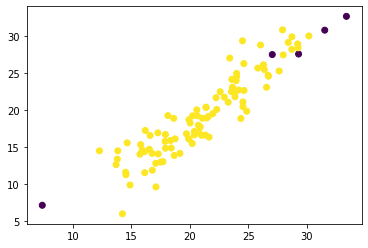

In [102]:
plt.scatter(call_types_min['Local'], call_types_min['Intl'], c=y_ctm)

In [103]:
df['startCallHour'].

0    11
1    18
2    15
3    19
4    14
Name: startCallHour, dtype: int64

In [104]:
X_new.head()

,destPhoneNumber,callDurationMin,startCallHour,Cost,Free,Intl,Local,Mobile,National,PRS,Outlier
phoneNumber,,,,,,,,,,,
1135222222,367,20.264305,16.694823,133.234332,4.0,26.0,224.0,71.0,40.0,2.0,1
1142444444,389,20.053985,16.331620,132.506427,2.0,32.0,228.0,74.0,53.0,0.0,1
1159888888,470,16.444681,16.244681,89.819149,4.0,30.0,305.0,78.0,50.0,3.0,1
1185333333,370,15.727027,16.845946,105.575676,2.0,27.0,222.0,79.0,39.0,1.0,1
1229211111,376,29.829787,16.446809,170.446809,2.0,17.0,258.0,60.0,36.0,3.0,1


In [106]:
X_new['Outlier'].unique()

array([ 1, -1], dtype=int64)

## EXERCISE

- Build a supervised learning model using as `y` the column `Outlier` that we created.
- Try `RandomForestClassifier` using `GridSearchCV` for the parameter `n_estimators`: 10,50,100, 100+.


In [105]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV